In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from torch.utils.data import Subset
from random import shuffle, sample
from copy import deepcopy
import torch.nn.functional as F

print(torch.cuda.is_available())

True


### Arguments

In [2]:
args = {
    'lr': 1e-3, 
    'bs': 128, 
    'epochs': 5, 
    'num_tasks': 5,
    'dataset': "MNIST",
    'num_classes': 10, 
    'in_size': 28,
    'n_channels': 1,
    'hidden_size': 50
    }

### Data

In [3]:

def get_dataset(dataroot, dataset):
    if dataset == 'MNIST':
        mean, std = (0.1307), (0.3081)
    elif dataset == 'CIFAR10':
        mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=std)])
    
    train_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=True,
        download=True,
        transform=transform
    )

    val_dataset = torchvision.datasets.__dict__[dataset](
        root=dataroot,
        train=False,
        download=True,
        transform=transform
    )
    
    return train_dataset, val_dataset


def split_dataset(dataset, tasks_split):
    split_dataset = {}
    for e, current_classes in tasks_split.items():
        task_indices = np.isin(np.array(dataset.targets), current_classes)
        split_dataset[e] = Subset(dataset, np.where(task_indices)[0])
    return split_dataset

### Metrics & plotting

In [4]:
def dict2array(acc):
    num_tasks = len(acc)
    first_task = list(acc.keys())[0]
    sequence_length = len(acc[first_task]) if isinstance(acc[first_task], list) else num_tasks
    acc_array = np.zeros((num_tasks, sequence_length))
    for task, val in acc.items():
        acc_array[int(task), :] = val
    return acc_array


def plot_accuracy_matrix(array):
    num_tasks = array.shape[1]
    array = np.round(array, 2)
    fig, ax = plt.subplots()
    ax.imshow(array, vmin=np.min(array), vmax=np.max(array))
    for i in range(len(array)):
        for j in range(array.shape[1]):
            ax.text(j,i, array[i,j], va='center', ha='center', c='w', fontsize=15)
    ax.set_yticks(np.arange(num_tasks))
    ax.set_ylabel('Number of tasks')
    ax.set_xticks(np.arange(num_tasks))
    ax.set_xlabel('Tasks finished')
    ax.set_title(f"ACC: {np.mean(array[:, -1]):.3f} -- std {np.std(np.mean(array[:, -1])):.3f}")
    plt.show()
    plt.savefig('matrix')


def plot_acc_over_time(array):
    fig, ax = plt.subplots()
    for e, acc in enumerate(array):
        ax.plot(acc, label=e)
    plt.legend()
    plt.show()
    plt.savefig('over_time')


def compute_average_accuracy(array):
    num_tasks = len(array)
    avg_acc = np.sum(array[:, -1], axis=0)/num_tasks
    return avg_acc


def compute_backward_transfer(array):
    num_tasks = len(array)
    diag = np.diag(array)[:-1] # Note, we do not compute backward transfer for the last task!
    end_acc = array[:-1, -1]
    bwt = np.sum(end_acc - diag)/(num_tasks - 1)
    return bwt


def compute_forward_transfer(array, b):
    num_tasks = len(array)
    sub_diag = np.diag(array, k=-1) # Note, we do not compute forward transfer for the first task!
    fwt = np.sum(sub_diag - b[1:])/(num_tasks - 1)
    return fwt

# EWC -- Exercise

In [5]:


class EWC(object):
    def __init__(self, model, dataset):

        self.model = model
        self.dataset = dataset

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        # Compute a diagonal of empirical Fisher Information Matrix
        self._precision_matrices = self._diag_fisher()

        # Create a frozen copy of NN-weights to compute the change of weights in penalty method
        for n, p in deepcopy(self.params).items():
            self._means[n] = p.data

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = p.data

        self.model.eval()
        for input in self.dataset:
            self.model.zero_grad()
            input = input.cuda()
            output = self.model(input).view(1, -1)
            label = output.max(1)[1].view(-1)
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            # We compute the gradients for empirical Fisher; don't use them for the update
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    """
      Write the method to compute EWC penalty. 
      Assume that method takes current model as an input.
    """
    def penalty(self, model):
        loss = 0
        for n, p in model.named_parameters():
            if p.requires_grad:
                _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
                loss += _loss.sum()
        return loss

## Class incremental model

In [6]:

class Agent:
    def __init__(self, args, train_datasets, val_datasets):
        self.args = args
        self.model = MLP(self.args)
        if torch.cuda.is_available():
            self.model.cuda()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args['lr'])
        self.criterion = torch.nn.CrossEntropyLoss()
        self.reset_acc()
        self.train_datasets = train_datasets
        self.val_datasets = val_datasets
    
    def reset_acc(self):
        self.acc = {key: [] for key in self.args['task_names']}
        self.acc_end = {key: [] for key in self.args['task_names']}

    def train(self):
        importance = 0.001
        sample_size = 1000
        for task, data in self.train_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=self.args['bs'], shuffle=True)
            print(task)
            """
             Use the access to the train_datasets and create a list of 
             randomly selected **previous** examples (of length sample_size).
             Pass that list with current model to the constructor of EWC class.
            """
            old_samples = []
            for key, val in self.train_datasets.items():
                if int(key) < int(task):
                    for i in sample(range(len(val)), sample_size):
                        old_samples.append(val.__getitem__(i)[0])
            ewc = EWC(self.model, old_samples)
            
            for epoch in range(self.args['epochs']):
                epoch_loss = 0
                total = 0
                correct = 0
                for e, (X, y) in enumerate(loader):
                    if torch.cuda.is_available():
                        X, y = X.cuda(), y.cuda()
                    output = self.model(X)
                    """
                     Modify the loss objective to include the EWC penalty after
                     finishing the first task. Use variable importance to scale
                     EWC loss.
                    """
                    loss = self.criterion(output, y) + int(int(task) > 0) * (importance * ewc.penalty(self.model))
                    self.optimizer.zero_grad()
                    loss.backward() 
                    self.optimizer.step()
                    epoch_loss += loss.item()
                    correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y)
                    total += len(X)
                    if e % 50 == 0:
                        self.validate()
                print(f"Epoch {epoch}: Loss {epoch_loss/e:.3f} Acc: {correct/total:.3f}")
            self.validate(end_of_epoch=True)


    @torch.no_grad()
    def validate(self, end_of_epoch=False):
        self.model.eval()
        for task, data in self.val_datasets.items():
            loader = torch.utils.data.DataLoader(data, batch_size=args['bs'], shuffle=True)
            correct, total = 0, 0
            for e, (X, y) in enumerate(loader):
                if torch.cuda.is_available():
                    X, y = X.cuda(), y.cuda()
                output = self.model(X)
                correct += torch.sum(torch.topk(output, axis=1, k=1)[1].squeeze(1) == y).item()
                total += len(X)
            self.acc[task].append(correct/total)
            if end_of_epoch:
                self.acc_end[task].append(correct/total)
        self.model.train()


class MLP(torch.nn.Module):
    def __init__(self, args):
        super().__init__()
        hidden_size = args['hidden_size']
        self.fc1 = torch.nn.Linear(args['in_size']**2 * args['n_channels'], hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, args['num_classes'])

    def forward(self, input):
        x = input.flatten(start_dim=1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [7]:
classes = list(range(args['num_classes']))
shuffle(classes)
class_split = {str(i): classes[i*2: (i+1)*2] for i in range(args['num_tasks'])}
args['task_names'] = list(class_split.keys())

0
Epoch 0: Loss 0.415 Acc: 0.858
Epoch 1: Loss 0.043 Acc: 0.988
Epoch 2: Loss 0.032 Acc: 0.990
Epoch 3: Loss 0.021 Acc: 0.994
Epoch 4: Loss 0.015 Acc: 0.995
1
Epoch 0: Loss 0.777 Acc: 0.804
Epoch 1: Loss 0.110 Acc: 0.962
Epoch 2: Loss 0.070 Acc: 0.977
Epoch 3: Loss 0.054 Acc: 0.983
Epoch 4: Loss 0.043 Acc: 0.987
2
Epoch 0: Loss 1.686 Acc: 0.613
Epoch 1: Loss 0.041 Acc: 0.987
Epoch 2: Loss 0.028 Acc: 0.991
Epoch 3: Loss 0.021 Acc: 0.993
Epoch 4: Loss 0.016 Acc: 0.995
3
Epoch 0: Loss 1.746 Acc: 0.469
Epoch 1: Loss 0.017 Acc: 0.995
Epoch 2: Loss 0.011 Acc: 0.996
Epoch 3: Loss 0.011 Acc: 0.997
Epoch 4: Loss 0.009 Acc: 0.998
4
Epoch 0: Loss 2.187 Acc: 0.736
Epoch 1: Loss 0.076 Acc: 0.973
Epoch 2: Loss 0.057 Acc: 0.982
Epoch 3: Loss 0.054 Acc: 0.981
Epoch 4: Loss 0.036 Acc: 0.988


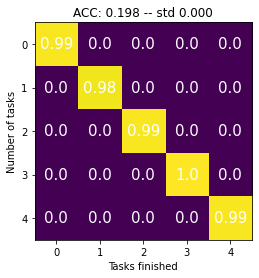

<Figure size 432x288 with 0 Axes>

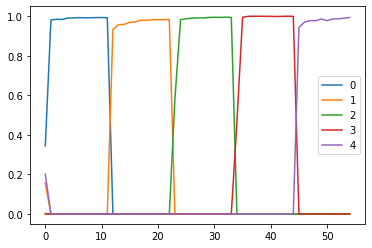

The average accuracy at the end of sequence is: 0.199
BWT:'-0.992'
FWT:'-0.138'


<Figure size 432x288 with 0 Axes>

In [8]:
train, test = get_dataset(dataroot='../data/', dataset=args['dataset'])
train_tasks = split_dataset(train, class_split)
val_tasks = split_dataset(test, class_split)
agent = Agent(args, train_tasks, val_tasks)

agent.validate()
random_model_acc = [i[0] for i in agent.acc.values()]
agent.reset_acc()
agent.train()

acc_at_end_arr = dict2array(agent.acc_end)
plot_accuracy_matrix(acc_at_end_arr)

acc_arr = dict2array(agent.acc)
plot_acc_over_time(acc_arr)

print(f"The average accuracy at the end of sequence is: {compute_average_accuracy(acc_at_end_arr):.3f}")
print(f"BWT:'{compute_backward_transfer(acc_at_end_arr):.3f}'")
print(f"FWT:'{compute_forward_transfer(acc_at_end_arr, random_model_acc):.3f}'")